In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")
from multiprocessing import Pool
from tqdm import tqdm
import statsmodels.api as sm
from datetime import datetime
import mplfinance as mpf
from functools import partial

In [22]:
stock_list = ff.read('close').index.str.startswith('300') | ff.read('close').index.str.startswith('688') | ff.read('close').index.str.endswith('BJ')

In [3]:
stock_list = ff.read('close').index[~stock_list]

In [4]:
time_list = ff.read('close').loc[:,'20200102':'20240305'].columns

In [5]:
filter0 = ff.filter0.loc[stock_list,time_list]
up = ff.read('up').loc[stock_list,time_list] * filter0
close = ff.read('close').loc[stock_list,time_list] * filter0
pre_close = ff.read('pre_close').loc[stock_list,time_list] *filter0
high = ff.read('high').loc[stock_list,time_list] * filter0
up_limit = ff.read('up_limit').loc[stock_list,time_list] * filter0

In [6]:
ret10 = high/close.shift(1,axis = 1)

In [7]:
ratio_8 = up.sum()/(ret10 >= 1.08).sum()
mean_8 = ratio_8.rolling(window = 10).mean()
ratio_9 = up.sum()/(ret10 >= 1.09).sum()
mean_9 = ratio_9.rolling(window = 10).mean()
ratio_10 = up.sum()/(ret10 >= 1.098).sum()
mean_10 = ratio_10.rolling(window = 10).mean()
print('8% mean',mean_8.mean())
print('8% median',mean_8.median())
print('9% mean',mean_9.mean())
print('9% median',mean_9.median())
print('10% mean',mean_10.mean())
print('10% median',mean_10.median())

8% mean 0.4032142092870353
8% median 0.4087854764243889
9% mean 0.5092777941953591
9% median 0.5154273931049631
10% mean 0.6189582642859737
10% median 0.6264107006647053


In [8]:
event = (ret10 >= 1.07) * up.replace({np.nan:True,1:False})

In [9]:
open_ = (ff.read('open')*ff.read('post')).loc[stock_list,time_list] * filter0
close_ = (ff.read('close')*ff.read('post')).loc[stock_list,time_list] * filter0
low_ = (ff.read('low')*ff.read('post')).loc[stock_list,time_list] * filter0
high_ = (ff.read('high')*ff.read('post')).loc[stock_list,time_list] * filter0

In [10]:
def daily_K_line(event,n,open,close,high,low):
    # 日均事件K线
    T0open=event*open  # 以T0open作为基准
    pre_close = event * close.shift(axis = 1)
    data=pd.DataFrame(columns=['T'+str(j) for j in range(n)])
    for j in range(n):
        _open=(event*open.shift(-j,axis=1))/pre_close
        _close=(event*close.shift(-j,axis=1))/pre_close
        _low=(event*low.shift(-j,axis=1))/pre_close
        _high=(event*high.shift(-j,axis=1))/pre_close
        lst=[_open.mean().mean(),_close.mean().mean(),_low.mean().mean(),_high.mean().mean()]
        data['T'+str(j)]=lst
    data.index=['open','close','low','high']
    data=data.T
    data.index=pd.to_datetime(['20200101','20200102','20200103','20200104','20200105'])
    mpf.plot(data,type='candle',style='default')
    return data

最高涨幅 >=7%


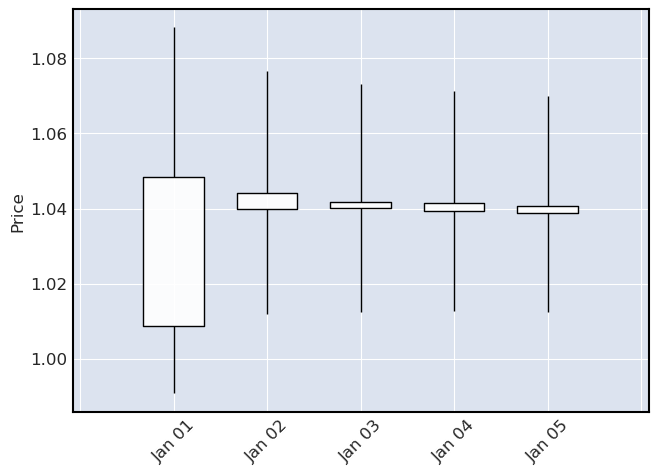

,open,close,low,high
2020-01-01,1.008806,1.048300,0.990730,1.088257
2020-01-02,1.039769,1.044216,1.011758,1.076684
2020-01-03,1.040045,1.041769,1.012454,1.073118
2020-01-04,1.039318,1.041531,1.012619,1.071433
2020-01-05,1.038882,1.040607,1.012450,1.069895


In [11]:
print('最高涨幅 >=7%')
daily_K_line(event,5,open_,close_,high_,low_)

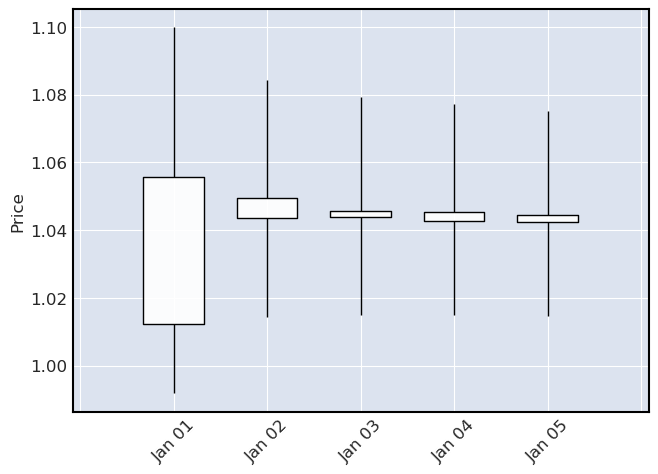

,open,close,low,high
2020-01-01,1.012302,1.055614,0.991772,1.099800
2020-01-02,1.043593,1.049407,1.014216,1.084394
2020-01-03,1.043921,1.045619,1.014833,1.079357
2020-01-04,1.042710,1.045382,1.014840,1.077124
2020-01-05,1.042418,1.044300,1.014752,1.075154


In [12]:
event = (ret10 >= 1.09) * up.replace({1:False,np.nan:True})
daily_K_line(event,5,open_,close_,high_,low_)

In [18]:
open_ = (ff.read('open')*ff.read('post')).loc[stock_list,time_list]
close_ = (ff.read('close')*ff.read('post')).loc[stock_list,time_list]
low_ = (ff.read('low')*ff.read('post')).loc[stock_list,time_list]
high_ = (ff.read('high')*ff.read('post')).loc[stock_list,time_list]

In [13]:
condition_1 = (high/pre_close > 1.075)
condition_2 = (close != up_limit).replace({True:1,False:0})
condition_2 = (condition_2.rolling(window = 5,axis = 1,closed = 'left').sum() == 5) #前五天的条件

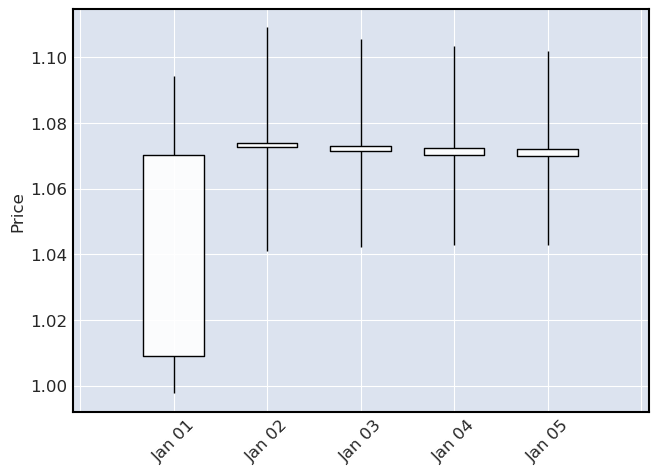

,open,close,low,high
2020-01-01,1.009025,1.070129,0.997619,1.094406
2020-01-02,1.072764,1.073967,1.040925,1.109111
2020-01-03,1.071370,1.073054,1.042358,1.105645
2020-01-04,1.070210,1.072514,1.042857,1.103572
2020-01-05,1.069867,1.072017,1.042952,1.102083


In [21]:
event = (condition_1 * condition_2).replace({False:np.nan})
daily_K_line(event * ff.filter0,5,open_,close_,high_,low_)

In [23]:
condition_1 = (close/pre_close > 1.075)
condition_2 = (close != up_limit).replace({True:1,False:0})
condition_2 = (condition_2.rolling(window = 5,axis = 1,closed = 'left').sum() == 5) #前五天的条件

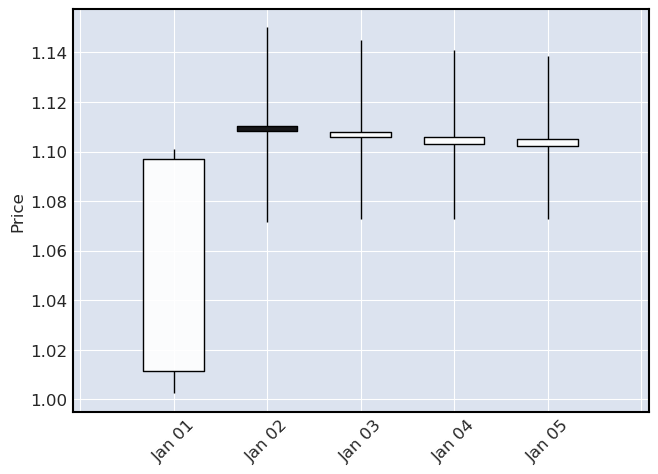

,open,close,low,high
2020-01-01,1.011436,1.097080,1.002379,1.101167
2020-01-02,1.110182,1.108445,1.071586,1.150102
2020-01-03,1.105911,1.107765,1.072745,1.144975
2020-01-04,1.103187,1.105881,1.072742,1.141154
2020-01-05,1.102142,1.105164,1.072579,1.138590


In [24]:
event = (condition_1 * condition_2).replace({False:np.nan})
daily_K_line(event * ff.filter0,5,open_,close_,high_,low_)